In [1]:
!pip install ultralytics
!pip install deep_sort_realtime
!pip install tensorflow
!pip install opencv-python
!pip install numpy
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split


In [3]:
def load_video_frames(video_path, num_frames=16, target_size=(64,64)):
    """
    Load `num_frames` evenly spaced frames from a video, resize, and normalize.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(total_frames // num_frames, 1)

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i*skip)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame / 255.0          # normalize 0-1
        frames.append(frame)

    cap.release()

    # If frames are less than num_frames, pad with last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)  # shape: (num_frames, H, W, C)


In [4]:
dataset_dir = "/content/drive/MyDrive/data1"
num_frames = 16
target_size = (64,64)

X, y = [], []
class_names = sorted(os.listdir(dataset_dir))

for label, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_dir, class_name)
    for video_file in os.listdir(class_folder):
        video_path = os.path.join(class_folder, video_file)
        frames = load_video_frames(video_path, num_frames=num_frames, target_size=target_size)
        X.append(frames)
        y.append(label)

X = np.array(X)  # shape: (num_videos, num_frames, H, W, C)
y = np.array(y)
print("Dataset shape:", X.shape, y.shape)
print("Classes:", class_names)


Dataset shape: (163, 16, 64, 64, 3) (163,)
Classes: ['a', 'f', 'n']


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:

from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# -----------------------
# 1. Setup models
# -----------------------
yolo_model = YOLO("yolov8n.pt")   # detects humans
tracker = DeepSort(max_age=30)    # tracks IDs

# -----------------------
# 2. 3D CNN definition
# -----------------------
num_frames = 16
img_size = (64,64)
num_classes = 5   # adjust to your dataset

input_shape = (num_frames, img_size[0], img_size[1], 3)

model = models.Sequential([
    layers.Conv3D(32, (3,3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),
    layers.Conv3D(128, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),
    layers.Conv3D(256, (1,2,2), activation='relu'),  # Changed kernel size again
    layers.MaxPooling3D((2,2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # -----------------------
# # 3. Video Processing
# # -----------------------
# def process_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     tracks_dict = {}   # store frame sequences per person ID

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Detect people
#         results = yolo_model.predict(frame, classes=[0]) # class 0 = person
#         detections = []
#         for r in results:
#             for box in r.boxes.xyxy.cpu().numpy():
#                 x1,y1,x2,y2 = box[:4]
#                 detections.append(([x1,y1,x2-x1,y2-y1], 1.0, 'person'))

#         # Track people
#         tracks = tracker.update_tracks(detections, frame=frame)

#         for track in tracks:
#             if not track.is_confirmed():
#                 continue
#             track_id = track.track_id
#             l,t,r,b = map(int, track.to_ltrb())
#             crop = frame[t:b, l:r]
#             if crop.size == 0:
#                 continue
#             crop = cv2.resize(crop, img_size)
#             crop = crop/255.0

#             if track_id not in tracks_dict:
#                 tracks_dict[track_id] = []
#             tracks_dict[track_id].append(crop)

#             # If enough frames collected, classify
#             if len(tracks_dict[track_id]) >= num_frames:
#                 clip = np.array(tracks_dict[track_id][:num_frames])
#                 clip = np.expand_dims(clip, axis=0)  # batch dimension
#                 pred = model.predict(clip)
#                 print(f"Person {track_id} -> Predicted class: {np.argmax(pred)}")

#                 # Optionally keep overlap frames
#                 tracks_dict[track_id] = tracks_dict[track_id][8:]

#     cap.release()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 14, 62, 62, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 12, 12, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 5, 5, 256)   │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 2, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,309 (2.57 MB)

 Trainable params: 674,309 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=4
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3374 - loss: 1.3522 - val_accuracy: 0.3939 - val_loss: 1.0974
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2943 - loss: 1.1953 - val_accuracy: 0.3030 - val_loss: 1.1748
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3063 - loss: 1.1519 - val_accuracy: 0.4545 - val_loss: 1.1300
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3504 - loss: 1.1434 - val_accuracy: 0.3939 - val_loss: 1.0796
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3328 - loss: 1.1202 - val_accuracy: 0.5758 - val_loss: 1.0905
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4624 - loss: 1.0150 - val_accuracy: 0.3333 - val_loss: 1.1688
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4605 - loss: 1.0258 - val_accuracy: 0.2424 - val_loss: 1.1954
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4841 - loss: 1.0074 - val_accuracy: 0.4848 - val_loss:

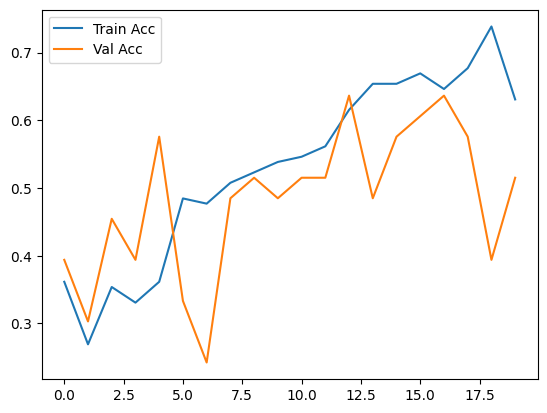

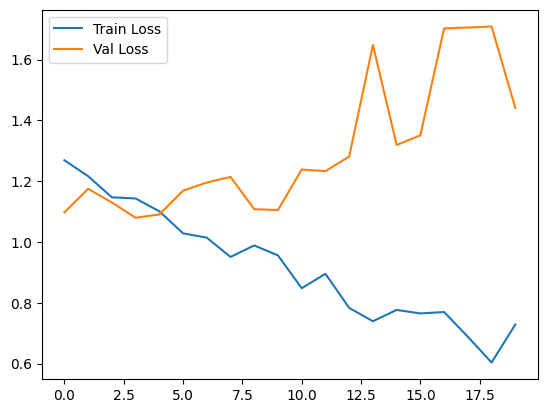

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


only prediction time use

In [10]:

# -----------------------------
# 11. Optional: Real-time tracking + behavior detection
# -----------------------------
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    tracks_dict = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect humans
        results = yolo_model.predict(frame, classes=[0])
        detections = []
        for r in results:
            for box in r.boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = box[:4]
                detections.append(([x1,y1,x2-x1,y2-y1], 1.0, 'person'))

        # Track humans
        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l,t,r,b = map(int, track.to_ltrb())
            crop = frame[t:b, l:r]
            if crop.size == 0:
                continue
            crop = cv2.resize(crop, img_size)
            crop = crop/255.0

            if track_id not in tracks_dict:
                tracks_dict[track_id] = []
            tracks_dict[track_id].append(crop)

            if len(tracks_dict[track_id]) >= num_frames:
                clip = np.array(tracks_dict[track_id][:num_frames])
                clip = np.expand_dims(clip, axis=0)
                pred = model.predict(clip)
                pred_class = class_names[np.argmax(pred)]
                print(f"Person {track_id}: {pred_class}")
                tracks_dict[track_id] = tracks_dict[track_id][8:]

    cap.release()

Update code final class find

In [12]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    tracks_dict = {}      # store frame sequences per person
    tracks_preds = {}     # store all predictions per person
    frame_count=0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        # Skip 9 frames, process only 1 every 10
        if frame_count % 10 != 0:
            continue
        # Detect humans
        results = yolo_model.predict(frame, classes=[0])
        detections = []
        for r in results:
            for box in r.boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = box[:4]
                detections.append(([x1,y1,x2-x1,y2-y1], 1.0, 'person'))

        # Track humans
        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l,t,r,b = map(int, track.to_ltrb())
            crop = frame[t:b, l:r]
            if crop.size == 0:
                continue
            crop = cv2.resize(crop, img_size)
            crop = crop / 255.0

            if track_id not in tracks_dict:
                tracks_dict[track_id] = []
                tracks_preds[track_id] = []  # initialize predictions list
            tracks_dict[track_id].append(crop)

            # If enough frames collected, classify
            if len(tracks_dict[track_id]) >= num_frames:
                clip = np.array(tracks_dict[track_id][:num_frames])
                clip = np.expand_dims(clip, axis=0)
                pred = model.predict(clip)
                pred_class = np.argmax(pred)
                tracks_preds[track_id].append(pred_class)  # store prediction

                # Keep overlap frames for smooth tracking
                tracks_dict[track_id] = tracks_dict[track_id][8:]

    cap.release()

    # Compute final class per person using majority vote
    from collections import Counter
    final_classes = {}
    for track_id, preds in tracks_preds.items():
        if len(preds) == 0:
            continue
        most_common = Counter(preds).most_common(1)[0][0]
        final_classes[track_id] = class_names[most_common]

    # Print final results
    for track_id, final_class in final_classes.items():
        print(f"Person {track_id} -> Final class: {final_class}")

    return final_classes  # optional return if needed for further use


In [13]:


video_path = "/content/drive/MyDrive/convet_action.mp4"
process_video(video_path)


0: 384x640 2 persons, 250.1ms
Speed: 4.6ms preprocess, 250.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 231.4ms
Speed: 4.2ms preprocess, 231.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 229.4ms
Speed: 8.4ms preprocess, 229.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 229.0ms
Speed: 3.7ms preprocess, 229.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 229.0ms
Speed: 3.9ms preprocess, 229.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 236.6ms
Speed: 3.9ms preprocess, 236.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 267.7ms
Speed: 5.1ms preprocess, 267.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 148.5ms
Speed: 3.7ms preprocess, 148.5ms inference, 1.3ms post

{'973': 'f',
 '975': 'f',
 '976': 'f',
 '985': 'f',
 '986': 'f',
 '990': 'f',
 '1008': 'f',
 '1011': 'f',
 '1012': 'f',
 '1014': 'f',
 '1016': 'f',
 '1022': 'f',
 '1025': 'f',
 '1026': 'f',
 '1030': 'f',
 '1031': 'f',
 '1039': 'f',
 '1040': 'f',
 '1042': 'f',
 '1044': 'f',
 '1046': 'f',
 '1047': 'f',
 '1052': 'a',
 '1053': 'f',
 '1059': 'f',
 '1062': 'f',
 '1065': 'f',
 '1066': 'f',
 '1070': 'f',
 '1071': 'f',
 '1086': 'f',
 '1087': 'f',
 '1096': 'f',
 '1098': 'f',
 '1103': 'f',
 '1106': 'f',
 '1110': 'f',
 '1120': 'f',
 '1122': 'f',
 '1129': 'f',
 '1131': 'f',
 '1136': 'f',
 '1128': 'f',
 '1144': 'f',
 '1142': 'f',
 '1148': 'f',
 '1149': 'f',
 '1150': 'f',
 '1151': 'f',
 '1159': 'f',
 '1164': 'f',
 '1165': 'f',
 '1166': 'f',
 '1167': 'f',
 '1168': 'f',
 '1171': 'f',
 '1177': 'f',
 '1178': 'f',
 '1182': 'f',
 '1199': 'f',
 '1210': 'f',
 '1214': 'f',
 '1215': 'f',
 '1223': 'f',
 '1224': 'f',
 '1231': 'f',
 '1248': 'f',
 '1250': 'f',
 '1258': 'f',
 '1269': 'f',
 '1279': 'f',
 '1284': 'f'

webcam use

In [ ]:
import cv2

cap = cv2.VideoCapture(0)  # 0 = default webcam


In [ ]:
def process_webcam_live():
    import cv2
    from collections import Counter

    tracks_dict = {}
    tracks_preds = {}

    cap = cv2.VideoCapture(0)  # use webcam
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        # Skip frames to reduce processing if needed
        if frame_count % 2 != 0:  # process every 2nd frame (adjust as needed)
            continue

        # Detect humans
        results = yolo_model.predict(frame, classes=[0])
        detections = []
        for r in results:
            for box in r.boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = map(int, box[:4])
                detections.append(([x1, y1, x2-x1, y2-y1], 1.0, 'person'))

        # Track humans
        tracks = tracker.update_tracks(detections, frame=frame)
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = map(int, track.to_ltrb())
            crop = frame[t:b, l:r]
            if crop.size == 0:
                continue
            crop_resized = cv2.resize(crop, img_size) / 255.0

            if track_id not in tracks_dict:
                tracks_dict[track_id] = []
                tracks_preds[track_id] = []

            tracks_dict[track_id].append(crop_resized)

            if len(tracks_dict[track_id]) >= num_frames:
                clip = np.array(tracks_dict[track_id][:num_frames])
                clip = np.expand_dims(clip, axis=0)
                pred = model.predict(clip)
                tracks_preds[track_id].append(np.argmax(pred))
                tracks_dict[track_id] = tracks_dict[track_id][8:]

            # Draw live bounding box + label
            if len(tracks_preds[track_id]) > 0:
                most_common = Counter(tracks_preds[track_id]).most_common(1)[0][0]
                label = class_names[most_common]
                cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
                cv2.putText(frame, f"ID {track_id}: {label}", (l, t-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Show live webcam
        cv2.imshow("Webcam Live Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Final class per person
    final_classes = {}
    for track_id, preds in tracks_preds.items():
        if len(preds) == 0:
            continue
        most_common = Counter(preds).most_common(1)[0][0]
        final_classes[track_id] = class_names[most_common]

    print("Final classes per person:", final_classes)
    return final_classes


In [ ]:
final_results = process_webcam_live()

